In [56]:
# imports
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [78]:
# function for bar plotting
def plot_bar(genomes, title, metric_func=roc_auc_score, metric_name='AUROC', fig_dir='figures', results_dir='results', model_types=[150, 300, 500, 1000], contig_lengths=[25, 50, 100, 150, 300, 500, 1000, 3000]):
    scores = np.zeros((len(model_types), len(contig_lengths)))
    for i, m in enumerate(model_types):
        for j, l in enumerate(contig_lengths):
            y_pred = np.empty((0))
            y_true = np.empty((0))

            for g in genomes:
                res = pd.read_csv(os.path.join(results_dir, g, f'{g}_{l}.fasta_gt1bp_dvfpred.txt'), sep="\t")
                m_res = res[res['model_contig_len'] == m]['score']
                y_pred = np.append(y_pred, m_res)

                if g.split('_')[0] == 'h':
                    y_true = np.append(y_true, np.zeros((len(m_res))))
                elif g.split('_')[0] == 'v':
                    y_true = np.append(y_true, np.ones((len(m_res))))
                else:
                    raise ValueError(f'Unknown identifier: {g.split("_")[0]} (should be h or v)')

            if metric_name == 'AUROC':
                scores[i][j] = metric_func(y_true, y_pred)
            else:
                scores[i][j] = metric_func(y_true, y_pred > 0.5)
                
    fig = plt.figure(facecolor='w', figsize=(10, 5))
    x = np.arange(len(contig_lengths))
    width = 0.2
    for i in range(len(model_types)):
        plt.bar(x + ((2*i-len(model_types)+1)/2)*width, scores[i], width, label=model_types[i], zorder=3)

    plt.xticks(x, contig_lengths)
    plt.xlabel('Input Contig Length')
    plt.yticks(np.linspace(0, 1, 11))
    plt.ylim([0, 1])
    plt.ylabel(f'{metric_name} Score')
    plt.grid(visible=True, axis='y', zorder=0)
    plt.legend(title='Model Contig Length')
    plt.title(f'{title} Dataset: {metric_name} Scores')
    plt.show()
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    fig.savefig(os.path.join(fig_dir, f'{title.lower()}_{metric_name.lower()}_bar.png'))

In [79]:
# function to compute all classification metrics
def compute_metrics(genomes, title, results_dir='results', model_types=[150, 300, 500, 1000], contig_lengths=[25, 50, 100, 150, 300, 500, 1000, 3000]):
    metrics = {}
    for l in contig_lengths:
        metrics[f'Input: {l}'] = {}
        for m in model_types:
            metrics[f'Input: {l}'][f'Model: {m}'] = {}
        
            y_pred = np.empty((0))
            y_true = np.empty((0))

            for g in genomes:
                res = pd.read_csv(os.path.join(results_dir, g, f'{g}_{l}.fasta_gt1bp_dvfpred.txt'), sep="\t")
                m_res = res[res['model_contig_len'] == m]['score']
                y_pred = np.append(y_pred, m_res)

                if g.split('_')[0] == 'h':
                    metrics[f'Input: {l}'][f'Model: {m}'][f'Genome score: {g}'] = 1 - m_res.mean()
                    y_true = np.append(y_true, np.zeros((len(m_res))))
                elif g.split('_')[0] == 'v':
                    metrics[f'Input: {l}'][f'Model: {m}'][f'Genome score: {g}'] = m_res.mean()
                    y_true = np.append(y_true, np.ones((len(m_res))))
                else:
                    raise ValueError(f'Unknown identifier: {g.split("_")[0]} (should be h or v)')

            metrics[f'Input: {l}'][f'Model: {m}']['Accuracy'] = accuracy_score(y_true, y_pred > 0.5)
            metrics[f'Input: {l}'][f'Model: {m}']['Precision'] = precision_score(y_true, y_pred > 0.5)
            metrics[f'Input: {l}'][f'Model: {m}']['Recall'] = recall_score(y_true, y_pred > 0.5)
            metrics[f'Input: {l}'][f'Model: {m}']['F1'] = f1_score(y_true, y_pred > 0.5)
            metrics[f'Input: {l}'][f'Model: {m}']['AUROC'] = roc_auc_score(y_true, y_pred)
                
    save_dir = os.path.join(results_dir, 'metrics')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    with open(os.path.join(save_dir, f'{title.lower()}_metrics.json'), 'w') as f:
        json.dump(metrics, f, indent=4)
    return metrics

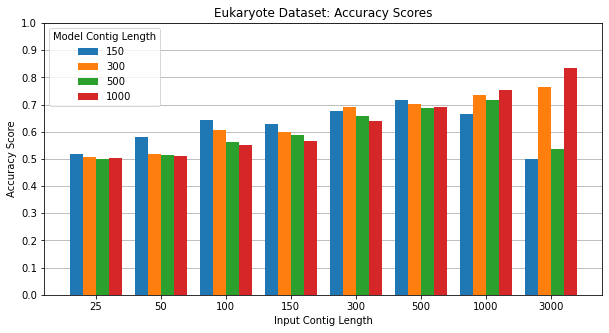

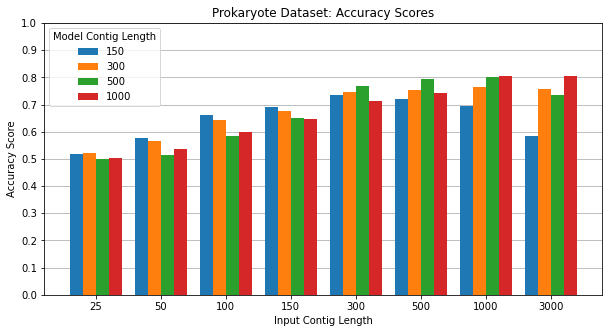

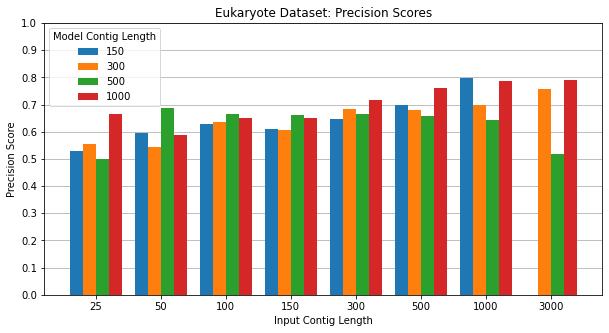

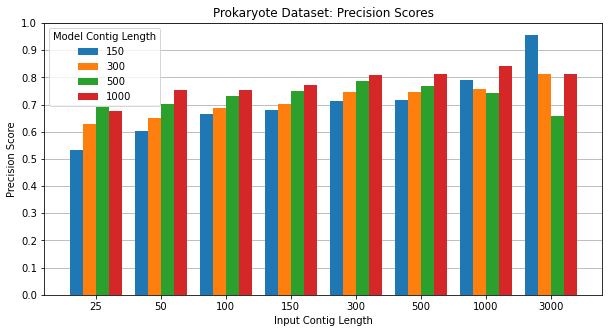

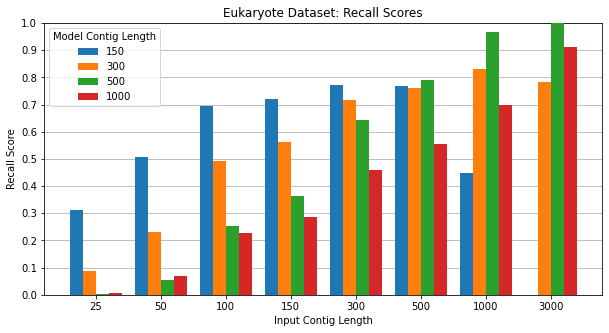

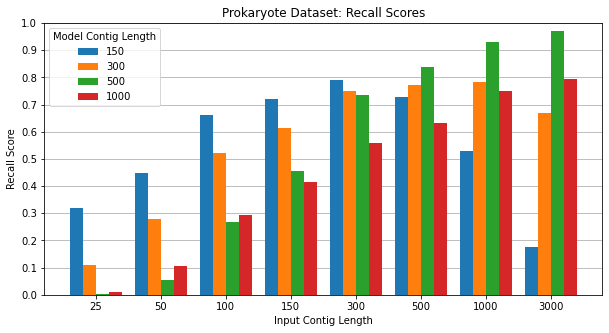

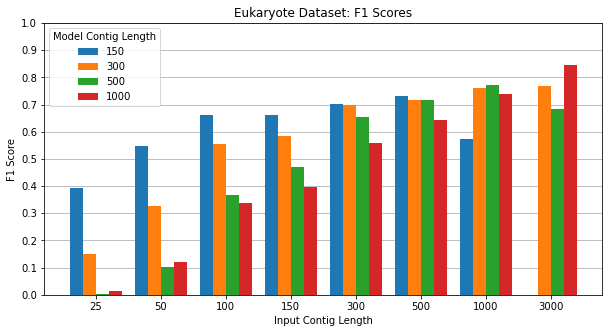

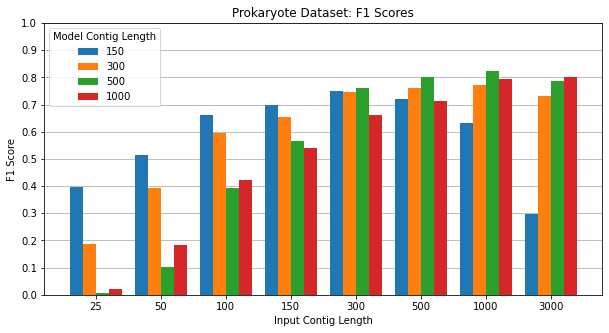

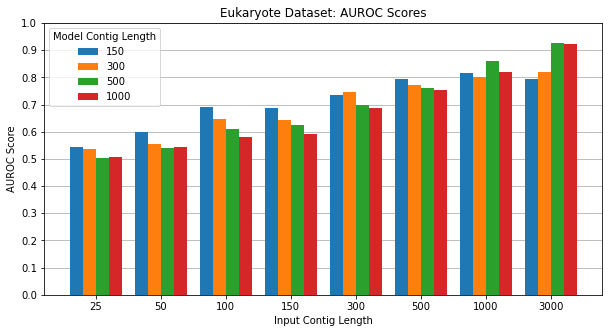

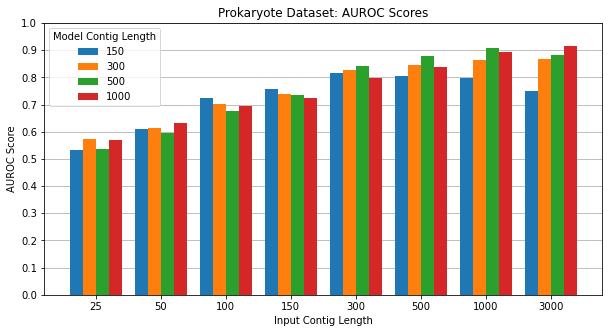

In [80]:
# parameters
euk_genomes = ['h_human-3', 'v_sars-cov-2']
prok_genomes = []
for genome in os.listdir(os.path.join('data', 'contigs')):
    if not genome in euk_genomes and ('v_' in genome or 'h_' in genome):
        prok_genomes.append(genome)

# plots
metric_funcs = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUROC']
for metric_func, metric_name in zip(metric_funcs, metric_names):
    for genomes, title in zip([euk_genomes, prok_genomes], ['Eukaryote', 'Prokaryote']):
        plot_bar(genomes, title, metric_func=metric_func, metric_name=metric_name)

# metrics
for genomes, title in zip([euk_genomes, prok_genomes], ['Eukaryote', 'Prokaryote']):
    compute_metrics(genomes, title)